In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/hw2

/content/drive/MyDrive/hw2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords

In [4]:
# Read the input text file into a DataFrame
df = pd.read_csv('data.txt')
df = df.sample(frac=1)

In [5]:
df = df.drop(columns=['Unnamed: 0'])

no_neutral = False

df = df.rename(columns={'text':'review', 'stars':'sentiment'})

if no_neutral:
    df = df[df['sentiment']!=3]
    df['sentiment'] = df['sentiment'].apply(lambda x: int(x>3))
else:
    df['sentiment'] = df['sentiment'].apply(lambda x: np.sign(x-3)+1)

In [6]:
from tensorflow.keras.utils import to_categorical

label = df.sentiment
label.unique()
num_classes = len(set(label))
one_hot_labels = to_categorical(label, num_classes=num_classes)

In [7]:
from gensim.parsing.porter import PorterStemmer
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
porter_stemmer = PorterStemmer()
review = df.review.values
review = [simple_preprocess(line, deacc=True) for line in review] 
review = [[porter_stemmer.stem(word) for word in tokens] for tokens in review]
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(review)
sequences = tokenizer.texts_to_sequences(review)

In [8]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

26781

In [9]:
maxlen = 200
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [10]:
from sklearn.model_selection import train_test_split
#split data into training and testing
padded_sequences, test_padded_sequences = train_test_split(padded_sequences, test_size=0.2, shuffle=False)
one_hot_labels, test_one_hot_labels = train_test_split(one_hot_labels, test_size=0.2, shuffle=False)

In [12]:
print(review[0])
print(sequences[0])

['don', 'let', 'the', 'small', 'underwhelm', 'build', 'fool', 'you', 'thi', 'restaur', 'ha', 'delici', 'authent', 'italian', 'food', 'the', 'servic', 'wa', 'excel']
[78, 282, 1, 189, 1310, 729, 2360, 19, 17, 75, 100, 167, 740, 635, 23, 1, 44, 4, 298]


In [14]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

num_classes = len(label.unique())
window_sizes = [2, 3, 4, 5]
num_filters = 10
architecture = "LSTM"
activation = "tanh"

if architecture == "LSTM":
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=30, input_length=maxlen))
    model.add(SpatialDropout1D(0.25))
    model.add(LSTM(64, activation=activation, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
else:
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=30, input_length=maxlen))
    model.add(SpatialDropout1D(0.25))
    model.add(Conv1D(num_filters, kernel_size=window_sizes[0], activation=activation))
    model.add(MaxPooling1D())
    for window_size in window_sizes[1:]:
        model.add(Conv1D(num_filters, kernel_size=window_size, activation=activation))
        model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 30)           803430    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 30)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                24320     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 827,945
Trainable params: 827,945
Non-trainable params: 0
__________________________________________________

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(padded_sequences,one_hot_labels,validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
600/600 [==============================] - 308s 506ms/step - loss: 0.8457 - accuracy: 0.5840 - val_loss: 0.7062 - val_accuracy: 0.6702
Epoch 2/20
600/600 [==============================] - 261s 435ms/step - loss: 0.6681 - accuracy: 0.7069 - val_loss: 0.7569 - val_accuracy: 0.6835
Epoch 3/20
600/600 [==============================] - 256s 426ms/step - loss: 0.6016 - accuracy: 0.7422 - val_loss: 0.6345 - val_accuracy: 0.7244
Epoch 4/20
600/600 [==============================] - 256s 426ms/step - loss: 0.5616 - accuracy: 0.7608 - val_loss: 0.6706 - val_accuracy: 0.7183
Epoch 5/20
600/600 [==============================] - 254s 423ms/step - loss: 0.5388 - accuracy: 0.7729 - val_loss: 0.6262 - val_accuracy: 0.7294
Epoch 6/20
600/600 [==============================] - 254s 424ms/step - loss: 0.5124 - accuracy: 0.7909 - val_loss: 0.6243 - val_accuracy: 0.7290
Epoch 7/20
600/600 [==============================] - 254s 423ms/step - loss: 0.4922 - accuracy: 0.7981 - val_loss: 0.6629 -

In [16]:
model.save('lstm_tanh.h5')

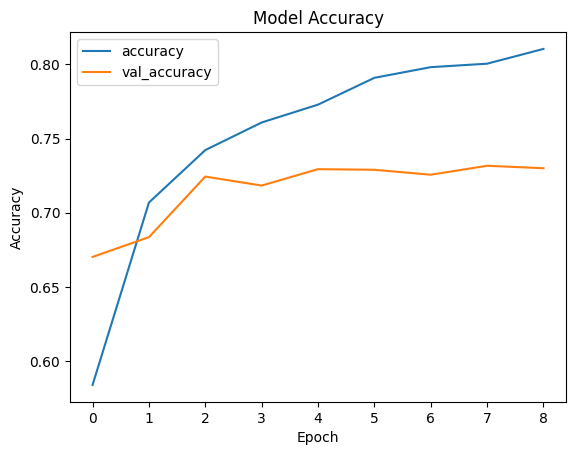

In [17]:
# Plot training and validation accuracy scores
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

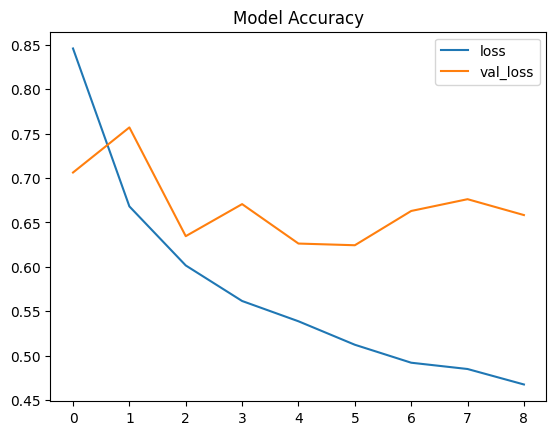

In [18]:
# Plot training and validation accuracy scores
plt.plot(history.history['loss'], label ='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_padded_sequences, test_one_hot_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

188/188 [==============================] - 13s 65ms/step - loss: 0.6856 - accuracy: 0.7222
Accuracy: 72.22%


In [20]:
from sklearn.metrics import classification_report

# Make predictions using the trained model
y_pred = model.predict(test_padded_sequences)

# Convert the predictions from probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(np.argmax(test_one_hot_labels, axis=1), y_pred))

188/188 [==============================] - 12s 64ms/step
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      2022
           1       0.61      0.62      0.62      1992
           2       0.76      0.83      0.79      1986

    accuracy                           0.72      6000
   macro avg       0.72      0.72      0.72      6000
weighted avg       0.72      0.72      0.72      6000

